# Anomaly Detection with Variational Autoencoders

In [1]:
import boto3
from   IPython                   import display
import matplotlib.pyplot         as plt
import numpy                     as np
import pandas                    as pd
import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker.tensorflow.serving import Model, Predictor
from sagemaker.tensorflow import TensorFlowModel, TensorFlowPredictor
from   sklearn.decomposition     import PCA
import tensorflow                as tf
from   tensorflow                import keras
from   tensorflow.keras.datasets import mnist
import tensorflow.keras.backend  as K
from scipy.stats import multivariate_normal
from scipy       import stats
from statistics  import mean
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import os
import sys

PATH = os.path.abspath('..')
if PATH not in sys.path:
    sys.path.append(PATH)
    
import src.config as config
from src import model_def

pd.set_option('display.max_columns', None)
tf.config.experimental.list_physical_devices('GPU')

[]

In [2]:
role   = sagemaker.get_execution_role()
region = boto3.Session().region_name
sm     = boto3.Session(region_name=region).client('sagemaker')

### Data Preparation

In [3]:
# Load MNIST Data
(train_x, train_y), (test_x, test_y) = mnist.load_data()
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

train_x = train_x.reshape((-1, 28, 28, 1))
test_x = test_x.reshape((-1, 28, 28, 1))
print(train_x.shape, test_x.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 28, 28, 1) (10000, 28, 28, 1)


#### Save data locally 

In [4]:
!mkdir -p ../data/train/
!mkdir -p ../data/test/

np.save('../data/train/train_x', train_x)
np.save('../data/test/test_x', test_x)
np.save('../data/train/train_y', train_y)
np.save('../data/test/test_y', test_y)

Upload data to s3 bucket

In [5]:
s3_prefix = 'VAE'
train_s3_prefix = f'{s3_prefix}/train'
test_s3_prefix = f'{s3_prefix}/test'

train_s3 = sagemaker.Session().upload_data(path = '../data/train', key_prefix = train_s3_prefix)
test_s3 = sagemaker.Session().upload_data(path = '../data/test', key_prefix = test_s3_prefix)

In [6]:
train_s3

's3://sagemaker-us-east-2-504928367736/VAE/train'

In [7]:
# Choose a number tobe anomaly number and separate from the rest
anomalyNumber = 5
validNumber = [1,4]
allNumbers = validNumber + [anomalyNumber]
train_validIdxs = np.where(np.isin(train_y, validNumber))[0] #np.where(train_y!=anomalyNumber)[0]
train_anomalyIdxs = np.where(train_y==anomalyNumber)[0]

test_validIdxs = np.where(np.isin(test_y, validNumber))[0] #np.where(test_y!=anomalyNumber)[0]
test_anomalyIdxs = np.where(test_y==anomalyNumber)[0]

In [8]:
# Data preparation
# Convert from integers to float32
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')

# Scale input tobe between 0 and 1
train_x = train_x / 255
test_x = test_x / 255

# One hot encoding output variables
train_y_one_hot = tf.keras.utils.to_categorical(train_y)
test_y_one_hot = tf.keras.utils.to_categorical(test_y)

In [9]:
print(train_x.shape, test_x.shape, train_y_one_hot.shape, test_y_one_hot.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000, 10) (10000, 10)


In [10]:
# Prepare normal data and anomalies
train_x_normal = train_x[train_validIdxs]
train_y_normal = train_y[train_validIdxs]

test_x_normal = test_x[test_validIdxs]
test_y_normal = test_y[test_validIdxs]

train_x_anomaly = train_x[train_anomalyIdxs]
train_y_anomaly = train_y[train_anomalyIdxs]
test_x_anomaly = test_x[test_anomalyIdxs]
test_y_anomaly = test_y[test_anomalyIdxs]
x_anomaly = np.concatenate([train_x_anomaly, test_x_anomaly])
y_anomaly = np.concatenate([train_y_anomaly, test_y_anomaly])

print(train_x_normal.shape, train_y_normal.shape, test_x_normal.shape, test_y_normal.shape,\
      x_anomaly.shape, y_anomaly.shape)

(12584, 28, 28, 1) (12584,) (2117, 28, 28, 1) (2117,) (6313, 28, 28, 1) (6313,)


### Visualizing the data

In [11]:
def generate_original_images(x):    
    plt.figure(figsize=(5,5))
    plt.title('input')
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i], cmap=plt.cm.binary)
    plt.show()

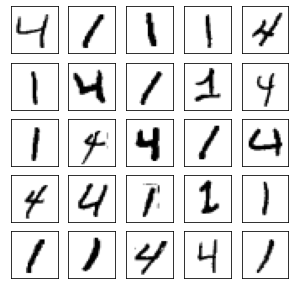

In [12]:
generate_original_images(train_x_normal[:25])

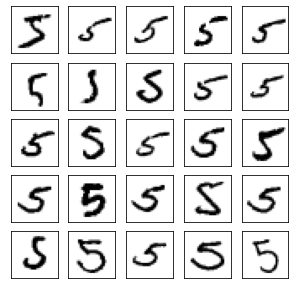

In [13]:
generate_original_images(x_anomaly[:25])

### Training

In [14]:
local_model_dir = '../model/' 
model_dir = '/opt/ml/model'
hyperparameters = {'epochs': config.EPOCHS,
                   'batch_size': config.BATCH_SIZE,
                   'learning_rate': config.LEARNING_RATE}

estimator = TensorFlow(
                       entry_point          = config.TRAIN_ENTRY_POINT,
                       source_dir           = config.TRAIN_SOURCE_DIR,
                       model_dir            = model_dir,
                       instance_type        = config.TRAIN_INSTANCE_TYPE,
                       instance_count       = config.TRAIN_INSTANCE_COUNT,
                       hyperparameters      = hyperparameters,
                       role                 = role,
                       base_job_name        = config.TRAIN_BASE_JOB_NAME,
                       framework_version    = config.TRAIN_FRAMEWORK_VERSION,
                       py_version           = config.TRAIN_PY_VERSION,
                       )

In [15]:
inputs = {'train': train_s3,
          'test': test_s3}

In [16]:
estimator.fit(inputs)

2021-06-28 23:53:30 Starting - Starting the training job...
2021-06-28 23:53:53 Starting - Launching requested ML instancesProfilerReport-1624924409: InProgress
......
2021-06-28 23:54:53 Starting - Preparing the instances for training......
2021-06-28 23:55:53 Downloading - Downloading input data
2021-06-28 23:55:53 Training - Downloading the training image...
2021-06-28 23:56:13 Training - Training image download completed. Training in progress.2021-06-28 23:56:13.132039: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-06-28 23:56:13.135696: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-06-28 23:56:13.278599: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-06-28 23:56:15,538 sagemaker-training-toolkit INFO     Imported framewo

### Downloading model artifact

In [17]:
model_artifacts_s3 = estimator.model_data
model_artifacts_s3

's3://sagemaker-us-east-2-504928367736/tf-eager-VAE-2021-04-21-19-33-16-419/output/model.tar.gz'

In [18]:
version = 'v1'
os.makedirs(f'../model/{version}', exist_ok=True)
!aws s3 cp {model_artifacts_s3} ../model/{version}/model.tar.gz
!tar -xzvf ../model/{version}/model.tar.gz -C ../model/{version}

download: s3://sagemaker-us-east-2-504928367736/tf-eager-VAE-2021-04-21-19-33-16-419/output/model.tar.gz to ../model/v1/model.tar.gz
encoder_sampler/
encoder_sampler/4/
encoder_sampler/4/saved_model.pb
encoder_sampler/4/variables/
encoder_sampler/4/variables/variables.index
encoder_sampler/4/variables/variables.data-00000-of-00001
encoder_sampler/4/assets/
decoder/
decoder/5/
decoder/5/saved_model.pb
decoder/5/variables/
decoder/5/variables/variables.index
decoder/5/variables/variables.data-00000-of-00001
decoder/5/assets/
train_loss.npy
encoder_lgvar/
encoder_lgvar/3/
encoder_lgvar/3/saved_model.pb
encoder_lgvar/3/variables/
encoder_lgvar/3/variables/variables.index
encoder_lgvar/3/variables/variables.data-00000-of-00001
encoder_lgvar/3/assets/
test_loss.npy
vae/
vae/1/
vae/1/saved_model.pb
vae/1/variables/
vae/1/variables/variables.index
vae/1/variables/variables.data-00000-of-00001
vae/1/assets/
encoder_mean/
encoder_mean/2/
encoder_mean/2/saved_model.pb
encoder_mean/2/variables/
en

### Deploy models to one endpoint

In [19]:
env = {
    'SAGEMAKER_TFS_DEFAULT_MODEL_NAME': config.SAGEMAKER_TFS_DEFAULT_MODEL_NAME
}


model = TensorFlowModel(model_data = model_artifacts_s3, 
              role = role, 
              framework_version = config.TRAIN_FRAMEWORK_VERSION,
              env = env)

predictor = model.deploy(initial_instance_count = config.INFERENCE_INITIAL_INSTANCE_COUNT,
                         instance_type = config.INFERENCE_INSTANCE_TYPE)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----------!

In [20]:
# get the endpoint name from the default predictor
endpoint = predictor.endpoint_name

# get a predictor for 'encoder_sampler'
encoder_mean_predictor = TensorFlowPredictor(endpoint, model_name = 'encoder_mean')
encoder_lgvar_predictor = TensorFlowPredictor(endpoint, model_name = 'encoder_lgvar')
encoder_sampler_predictor = TensorFlowPredictor(endpoint, model_name = 'encoder_sampler')
decoder_predictor = TensorFlowPredictor(endpoint, model_name = 'decoder')

### Plot images and predictions

In [21]:
def generate_prediction_images(x):
    z_mean = encoder_mean_predictor.predict(x)['predictions']
    z_lgvar = encoder_lgvar_predictor.predict(x)['predictions']
    x_pred = predictor.predict(x)['predictions']
        
    plt.figure(figsize=(5,5))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_pred[i], cmap=plt.cm.binary)
    plt.show()
    
def generate_original_images(x):    
    plt.figure(figsize=(5,5))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i], cmap=plt.cm.binary)
    plt.show()

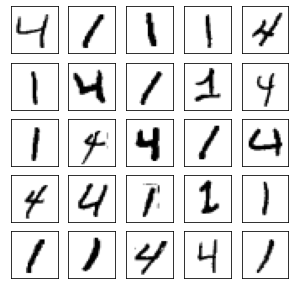

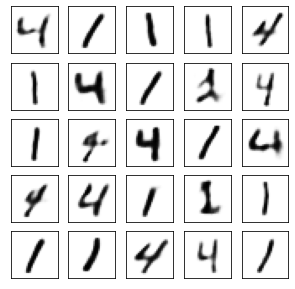

In [22]:
generate_original_images(train_x_normal[:25])
generate_prediction_images(train_x_normal[:25])

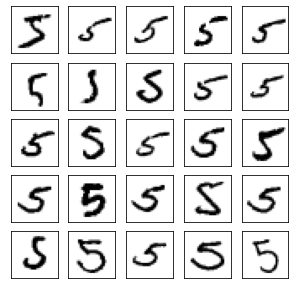

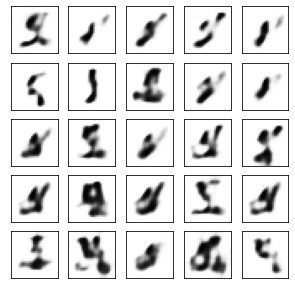

In [23]:
generate_original_images(x_anomaly[:25])
generate_prediction_images(x_anomaly[:25])

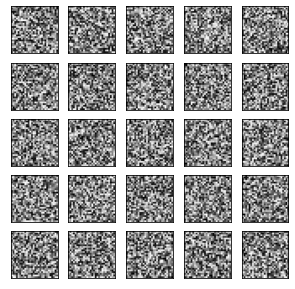

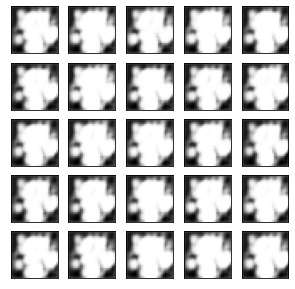

In [24]:
anomaly_random = np.random.random(size=(50, 28, 28, 1))
generate_original_images(anomaly_random[:25])
generate_prediction_images(anomaly_random[:25])

### PCA of hidden vectors

In [25]:
train_x = np.concatenate((train_x_normal[:1400], x_anomaly[:700]), axis=0)
train_y = np.concatenate((train_y_normal[:1400], y_anomaly[:700]))

In [26]:
#PCA on the latent variables
train_x_hidden = encoder_sampler_predictor.predict(train_x)['predictions']

In [27]:
np.shape(train_x_hidden)

(2100, 16)

In [28]:
pca_3d = PCA(n_components = 3)
PCA_hidden_3d = pca_3d.fit_transform(train_x_hidden)

pca_2d = PCA(n_components = 2)
PCA_hidden_2d = pca_2d.fit_transform(train_x_hidden)

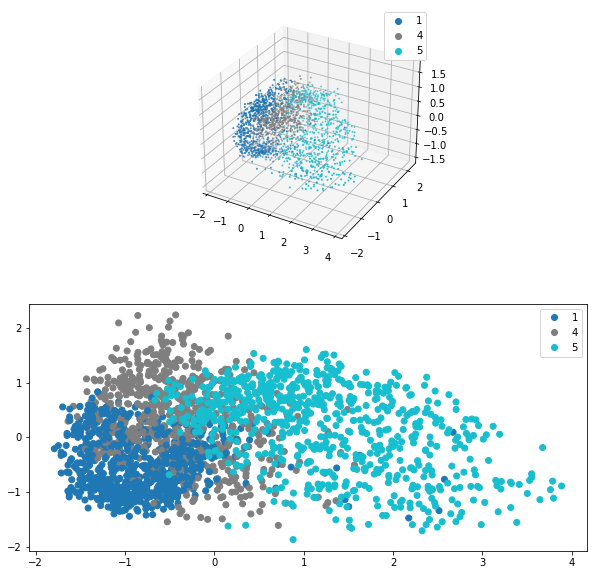

In [29]:
fig = plt.figure(figsize=(10,10))

ax0 = fig.add_subplot(211, projection='3d')
p0  = ax0.scatter(PCA_hidden_3d[:, 0], PCA_hidden_3d[:, 1],
                  PCA_hidden_3d[:, 2], c=train_y, cmap='tab10', s=1)
plt.legend(handles=p0.legend_elements()[0], labels=allNumbers)
plt.show

ax1 = fig.add_subplot(212)
p1 = ax1.scatter(PCA_hidden_2d[:,0], PCA_hidden_2d[:, 1], c =train_y, 
              cmap='tab10') #matplotlib.colors.ListedColormap(colors))
plt.legend(handles=p1.legend_elements()[0], labels=allNumbers)
plt.show()

### Reconstruction Error

In [30]:
def compute_reconstruction_error(predictor, x):
    x_pred  = predictor.predict(x)['predictions']
    cross_ent = K.binary_crossentropy(x, x_pred)
    recon = tf.reduce_sum(cross_ent, axis=[1,2,3]) #consolidate at each instance
    
    return recon

In [31]:
train_normal_recon_loss   = compute_reconstruction_error(predictor, train_x_normal[:2000])
test_normal_recon_loss    = compute_reconstruction_error(predictor, test_x_normal[:2000])
anomaly_recon_loss = compute_reconstruction_error(predictor, x_anomaly[:2000])
anomaly_random = np.random.random(size=(config.BATCH_SIZE, 28, 28, 1)).tolist()
anomaly_random_recon_loss = compute_reconstruction_error(predictor, anomaly_random)

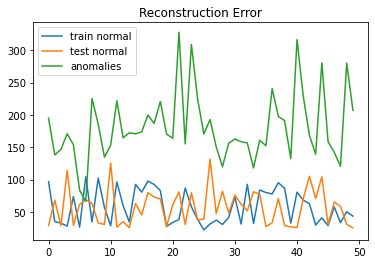

In [42]:
plt.plot(train_normal_recon_loss[:50], label = 'train normal')
plt.plot(test_normal_recon_loss[:50], label = 'test normal')
plt.plot(anomaly_recon_loss[:50], label = 'anomalies')
# plt.plot(anomaly_random_recon_loss[:50], label = 'random')
plt.title('Reconstruction Error')
plt.legend()
plt.show()

In [44]:
print(stats.describe(train_normal_recon_loss))
print(stats.describe(anomaly_recon_loss))
print(stats.describe(anomaly_random_recon_loss))

DescribeResult(nobs=2000, minmax=(18.145983, 174.11658), mean=55.147236, variance=621.8128, skewness=0.7809744477272034, kurtosis=0.28425512939658093)
DescribeResult(nobs=2000, minmax=(63.064354, 629.52136), mean=196.24976, variance=3778.812, skewness=1.5431115627288818, kurtosis=5.118014434009865)


### Evaluate the Model Performance

In [45]:
print(f'1, 99% Percentile of normal reconstruction loss is {np.percentile(train_normal_recon_loss, 1)}, {np.percentile(train_normal_recon_loss, 99)}')
print(f'4, 99% Percentile of abnormal reconstruction loss is {np.percentile(anomaly_recon_loss, 4)}, {np.percentile(anomaly_recon_loss, 99)}')

1, 99% Percentile of normal reconstruction loss is 24.860720615386963, 122.17086509704589
4, 99% Percentile of abnormal reconstruction loss is 118.42932067871094, 381.3654159545898


In [46]:
threshold = np.ceil(np.percentile(train_normal_recon_loss, 99))
threshold

123.0

In [36]:
# 1 - anomaly, 0 - normal
test_y_labels = np.concatenate([test_y_normal[:2000], y_anomaly[:2000]], axis=0)
test_y_labels[np.where(np.isin(test_y_labels, validNumber))[0]] = [False]*len(np.where(np.isin(test_y_labels, validNumber))[0])
test_y_labels[np.where(test_y_labels==anomalyNumber)[0]] = [True]*len(np.where(test_y_labels==anomalyNumber))
# print(test_y_labels.shape, test_recon_loss.shape)

test_recon_loss = np.concatenate([test_normal_recon_loss.numpy(), anomaly_recon_loss.numpy()], axis=0)
test_y_pred = np.array([1 if x>threshold else 0 for x in test_recon_loss])

In [37]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_y_labels, test_y_pred)
print('Accuracy: %f' % accuracy, '\n')
# precision tp / (tp + fp)
precision = precision_score(test_y_labels, test_y_pred)
print('Precision: %f' % precision, '\n')
# recall: tp / (tp + fn)
recall = recall_score(test_y_labels, test_y_pred)
print('Recall: %f' % recall, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y_labels, test_y_pred)
print('F1 score: %f' % f1, '\n')
 
# kappa
kappa = cohen_kappa_score(test_y_labels, test_y_pred)
print('Cohens kappa: %f' % kappa, '\n')
# ROC AUC
auc = roc_auc_score(test_y_labels, test_y_pred)
print('ROC AUC: %f' % auc, '\n')
# confusion matrix
matrix = confusion_matrix(test_y_labels, test_y_pred)
print('Confusion Matrix:', '\n', matrix, '\n')

Accuracy: 0.968250 

Precision: 0.987507 

Recall: 0.948500 

F1 score: 0.967610 

Cohens kappa: 0.936500 

ROC AUC: 0.968250 

Confusion Matrix: 
 [[1976   24]
 [ 103 1897]] 



### Cleaning up

In [40]:
# delete the SageMaker endpoint
predictor.delete_endpoint()